#

# Salmon Price Predictions
### Jesper Bengston

## Understanding the problem
I wish to predict salmon prices in Norway using a time series analysis. Currently the salmon price is hidden for the consumers and is provided one week behind the real market. Thus, with this forcasts we can provide approximate daily prices, aiding the procurer in getting a good price. Using longer forecast, or operating with the real-time price data, one could provide the exporter with the best selling time based on forecasted prices. Other domestic markets may also be interested in this data for own pricing.

### Other potential factors
Gas and electricity prices. Reputation, see salmar and dead fish for an example, also consider newscycle with fish welfare. Potentially competing markets, scotland, alaska, chile. 

### Python Code for Data Gathering and Cleaning

In [2]:
# Import necessary packages

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional scientific computing functions
from scipy import stats
from datetime import datetime
from scipy.interpolate import CubicSpline

# Ensure plots are displayed inline in Jupyter Notebooks
%matplotlib inline

# Set plot style for better visualization
sns.set(style="whitegrid")


### Import price data from Statistisk Sentralbyrå

In [2]:
# Create data frames

df_price = pd.read_csv('price.csv', delimiter=';', header=None) 
df_price.columns = ["comodity", "week", "weight", "price"]
df_price = df_price[['week', 'price']]

In [3]:
# Function to convert week format to ISO date (start of the week)
def week_to_iso_date(week_str):
    year = int(week_str[:4])
    week = int(week_str[5:])
    return datetime.fromisocalendar(year, week, 1)

# Apply the conversion function
df_price['week'] = df_price['week'].apply(week_to_iso_date)

df_price.set_index('week', inplace=True)

print(df_price.head)

<bound method NDFrame.head of             price
week             
2000-01-03  30.98
2000-01-10  31.12
2000-01-17  31.03
2000-01-24  30.95
2000-01-31  31.30
...           ...
2024-07-22  81.55
2024-07-29  81.19
2024-08-05  80.41
2024-08-12  80.89
2024-08-19  76.82

[1286 rows x 1 columns]>


### Perform some visual analysis on the price data

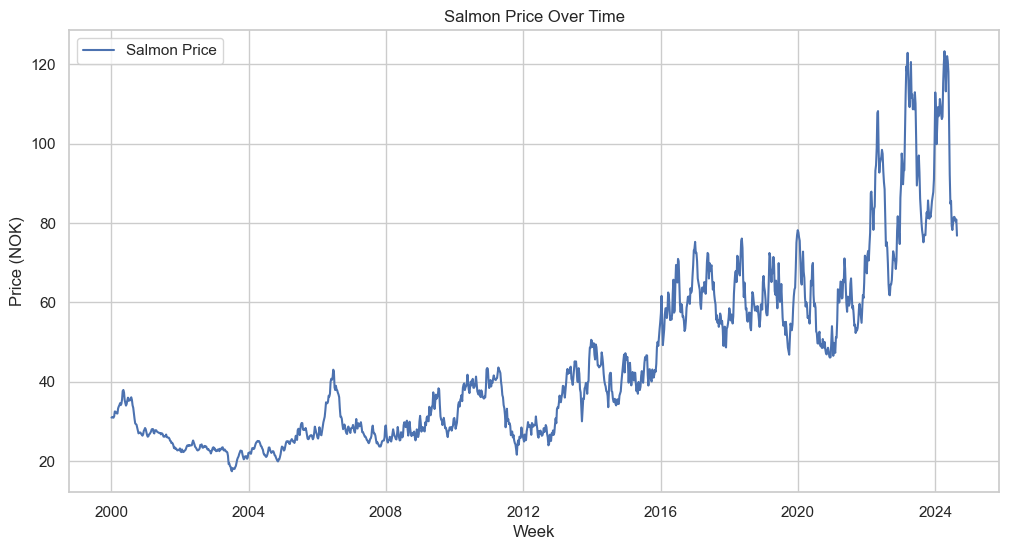

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df_price.index, df_price['price'], label='Salmon Price')
plt.xlabel('Week')
plt.ylabel('Price (NOK)')
plt.title('Salmon Price Over Time')
plt.legend()
plt.show()

C:\Users\jespe\AppData\Local\Temp\ipykernel_38624\4085250615.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_year = df_price.last('2Y')
C:\Users\jespe\AppData\Local\Temp\ipykernel_38624\4085250615.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  last_year = df_price.last('2Y')


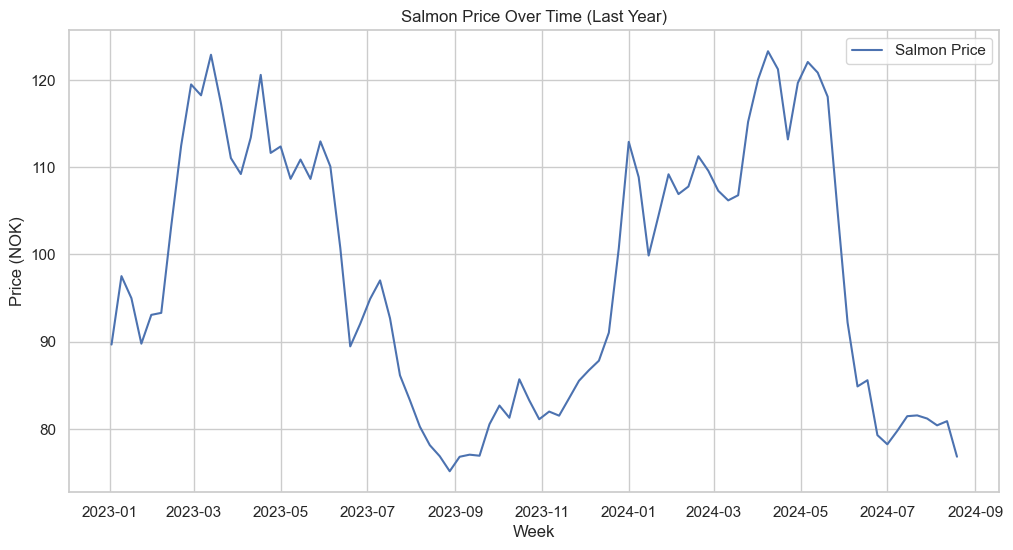

In [5]:
last_year = df_price.last('2Y')

# Plot the last year's data
plt.figure(figsize=(12, 6))
plt.plot(last_year.index, last_year['price'], label='Salmon Price')
plt.xlabel('Week')
plt.ylabel('Price (NOK)')
plt.title('Salmon Price Over Time (Last Year)')
plt.legend()
plt.show()

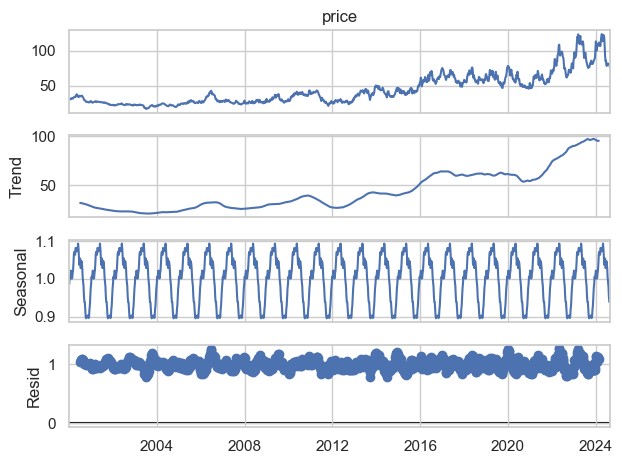

In [6]:
decomposition = seasonal_decompose(df_price['price'], model='multiplicative', period=52)

# Plot the decomposed components
decomposition.plot()
plt.show()


In [7]:
adf_result = adfuller(df_price['price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -0.8616334993421565
p-value: 0.8003444389844886


In [8]:
df_price['price_diff'] = df_price['price'].diff().dropna()

# Check stationarity after differencing
adf_result_diff = adfuller(df_price['price_diff'].dropna())
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

ADF Statistic (Differenced): -10.220849571118643
p-value (Differenced): 5.3298218295603406e-18


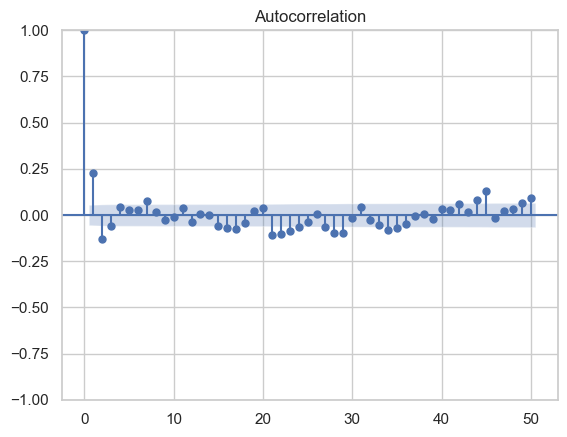

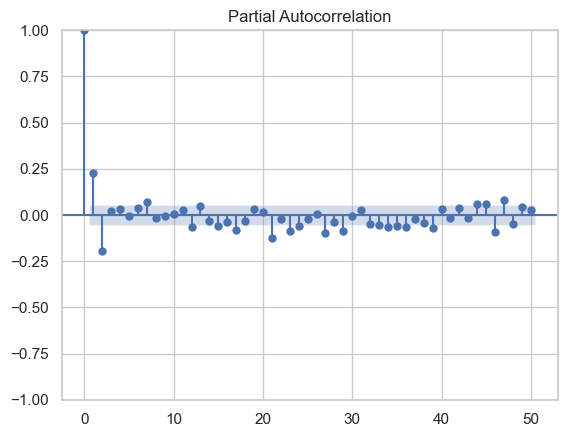

In [9]:
# Plot ACF and PACF for the differenced data
plot_acf(df_price['price_diff'].dropna(), lags=50)
plot_pacf(df_price['price_diff'].dropna(), lags=50)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5797.407, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5897.188, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5831.214, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5802.340, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5895.472, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5786.249, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5784.702, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5786.089, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5785.560, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5782.961, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5829.384, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5784.337, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5784.501, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5795.599, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]          

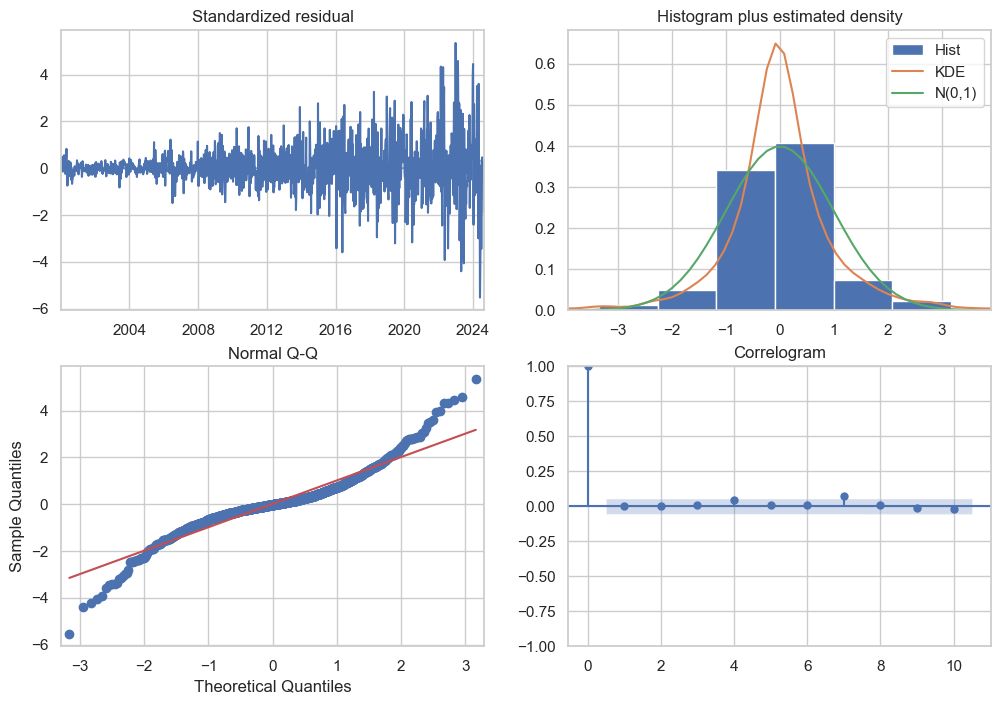

In [10]:
model = pm.auto_arima(df_price['price'], 
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      seasonal=False,
                      d=None,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the summary of the model
print(model.summary())

print(f"Selected ARIMA model: {model.order}")

model.plot_diagnostics(figsize=(12, 8))
plt.show()

### Import biomass data from Fiskeridirektoratet

In [12]:
# Create the data frame for biomass data
df_bio = pd.read_csv('biomass.csv', delimiter=';')

In [13]:
def to_iso_date(year, month):
    # Combine year and month to create the first day of the month
    return datetime(year, month, 1)

In [14]:
df_bio['week'] = df_bio.apply(lambda row: to_iso_date(row['ÅR'], row['MÅNED_KODE']), axis=1)

In [15]:
df_bio = df_bio[df_bio['ARTSID'] != 'REGNBUEØRRET']

# Remove unwanted columns
df_bio = df_bio[['week', 'FYLKE', 'BIOMASSE_KG', 'FORFORBRUK_KG', 'UTTAK_KG']]

# Rename the columns
df_bio.columns = ['week', 'fylke', 'biomass', 'feed', 'removed']

# Group by week aqnd fylke
df_bio = df_bio.groupby(['week', 'fylke']).agg({
    'biomass': 'sum',
    'feed': 'sum',
    'removed': 'sum'
}).reset_index()

df_bio.set_index('week', inplace=True)

print(df_bio.head())

               fylke     biomass     feed    removed
week                                                
2005-01-01      MogR  34790280.3  4182886  5651840.8
2005-01-01  Nordland  65690063.3  8755336  6477844.0
2005-01-01     RogAg  35934738.3  5202050  2339420.0
2005-01-01      TogF  52948857.5  4789590  6650319.0
2005-01-01      Tron  69710221.4  8267682  6109013.5


### Import sea temp data from Barentswatch

In [104]:
# Get sea temperature data from Barentswatch
df_temp = pd.read_csv('lice.csv')

df_temp = df_temp[:-4]

# Reverse the order of rows
df_temp = df_temp.iloc[::-1].reset_index(drop=True)

In [105]:
# Function to convert week format to ISO date modified to work with Barentswatch data
def week_year_to_date(year, week):
    return datetime.fromisocalendar(year, week, 1)

In [106]:
# Create week variable for df_temp
df_temp['week'] = df_temp.apply(lambda row: week_year_to_date(int(row['År']), int(row['Uke'])), axis=1)

In [107]:
# Remove unwanted data
df_temp = df_temp[['week', 'Fylke', 'Sjøtemperatur']]

df_temp.columns = ['week', "fylke", 'sea_temp']

In [108]:
# Join Agder and Rogaland as well as Troms and Finnmark, as it is consistent with the biomass data
region_mapping = {
    'Agder': 'RogAg',
    'Rogaland': 'RogAg',
    'Troms': 'TogF',
    'Finnmark': 'TogF'
}

# Apply the mapping to the fylke column
df_temp['fylke'] = df_temp['fylke'].replace(region_mapping)

In [109]:
df_temp = df_temp.groupby(['week', 'fylke'], as_index=False).agg({'sea_temp': 'mean'})

df_temp.set_index('week', inplace=True)

In [22]:
na_locations = df_temp[df_temp.isna().any(axis=1)]
print(na_locations)

                        fylke  sea_temp
week                                   
2012-04-09         Aust-Agder       NaN
2012-04-16         Aust-Agder       NaN
2012-04-23         Aust-Agder       NaN
2012-04-30         Aust-Agder       NaN
2019-04-22         Aust-Agder       NaN
2024-01-01  Troms og Finnmark       NaN


### Import wind data from MET

In [110]:
df_wind = pd.read_csv('met.csv', delimiter=';', parse_dates=['Tid(norsk normaltid)'], dayfirst=True)

# Rename columns
df_wind.columns = ['name', 'station', 'date', 'wind']

# Convert date to iso standard
df_wind['date'] = df_wind['date'].dt.strftime('%Y-%m-%d')

df_wind.set_index('date', inplace=True)

# Last row is not a data point
df_wind = df_wind.drop(df_wind.index[-1])

df_wind.index = pd.to_datetime(df_wind.index, format='%Y-%m-%d')

In [111]:
grouped = df_wind.groupby('name')

In [113]:
dfs = []
for name, group in grouped:
    # Create a complete date range
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
    
    group_reindexed = group.reindex(full_index)
    
    dfs.append(group_reindexed)

df_wind = pd.concat(dfs)

df_wind.reset_index(inplace=True)
df_wind.rename(columns={'index': 'date'}, inplace=True)

df_wind.set_index(['date'], inplace=True)
df_wind = df_wind[['name', 'wind']]

df_wind['name'] = df_wind['name'].ffill()
df_wind['wind'] = df_wind['wind'].str.replace(',', '.').astype(float)

df_wind['wind'] = df_wind['wind'].interpolate(method='linear')

In [ ]:
print(df_wind['name'].unique())

['Fedje' 'Halten Fyr' 'Kvitsøy - Nordbø' 'Myken' 'Måsvik' 'Oksøy Fyr'
 'Ona Ii' 'Svenner Fyr']


In [114]:
# Map the names
name_to_fylke = {
    'Fedje': 'Vestland',
    'Halten Fyr': 'Tron',
    'Kvitsøy - Nordbø': 'RogAg',
    'Myken': 'Nordland',
    'Måsvik': 'TogF',
    'Oksøy Fyr': 'RogAg',
    'Ona Ii': 'MogR',
    'Svenner Fyr': 'Vestfold'
}

# Apply the mapping to the fylke column
df_wind['name'] = df_wind['name'].replace(name_to_fylke)

df_wind.rename(columns={'name': 'fylke'}, inplace=True)

# Join the rows for Kvistøy and Oksøy as they are the same region but seperate fylke
df_wind = df_wind.groupby(['date', 'fylke']).mean().reset_index()

df_wind.set_index('date', inplace=True)

### Create daily and weekly data frames from the above df
#### Daily price

In [ ]:
# First create daily versions of weekly df and weekly df for daily
D_price_index = pd.date_range(start=df_price.index.min(), end=df_price.index.max(), freq='D')

df_price_D = df_price.reindex(D_price_index)

df_price_D.rename_axis('date', inplace=True)

# Interpolate using qubic splines
df_price_D['price'] = df_price_D['price'].astype(float)

df_price_D['price'] = df_price_D['price'].interpolate(method='cubicspline')

# After some deliberation chose to use data from 2012 and onwards
df_price_D = df_price_D[df_price_D.index >= '2012-01-01']

print(df_price_D.head)

<bound method NDFrame.head of                 price
date                 
2012-01-01  25.824361
2012-01-02  25.650000
2012-01-03  25.457106
2012-01-04  25.262204
2012-01-05  25.085077
...               ...
2024-08-15  80.167753
2024-08-16  79.632814
2024-08-17  78.912039
2024-08-18  77.982182
2024-08-19  76.820000

[4615 rows x 1 columns]>


#### Daily biomass

In [ ]:
# Create df_bio_sum that is the total biomass in every fylke
df_bio_sum = df_bio.groupby(df_bio.index).sum()
df_bio_sum = df_bio_sum[['biomass', 'feed', 'removed']]

# First create daily versions of weekly df and weekly df for daily
D_bio_index = pd.date_range(start=df_bio.index.min(), end=df_bio.index.max(), freq='D')

df_bio_D = df_bio_sum.reindex(D_bio_index)

df_bio_D.rename_axis('date', inplace=True)

# Interpolate using qubic splines
df_bio_D[['biomass', 'feed', 'removed']] = df_bio_D[['biomass', 'feed', 'removed']].astype(float)

df_bio_D[['biomass', 'feed', 'removed']] = df_bio_D[['biomass', 'feed', 'removed']].interpolate(method='cubicspline')

# After some deliberation chose to use data from 2012 and onwards
df_bio_D = df_bio_D[df_bio_D.index >= '2012-01-01']

print(df_bio_D.head)

<bound method NDFrame.head of                  biomass          feed       removed
date                                                
2012-01-01  6.807599e+08  9.606030e+07  8.364695e+07
2012-01-02  6.804676e+08  9.548199e+07  8.306835e+07
2012-01-03  6.801389e+08  9.488432e+07  8.249654e+07
2012-01-04  6.797750e+08  9.426945e+07  8.193377e+07
2012-01-05  6.793767e+08  9.363952e+07  8.138228e+07
...                  ...           ...           ...
2024-06-27  8.384615e+08  2.070554e+08  1.296429e+08
2024-06-28  8.401132e+08  2.096221e+08  1.304783e+08
2024-06-29  8.417952e+08  2.122725e+08  1.313271e+08
2024-06-30  8.435078e+08  2.150088e+08  1.321894e+08
2024-07-01  8.452517e+08  2.178327e+08  1.330654e+08

[4566 rows x 3 columns]>


#### Daily sea temp

In [ ]:
df_temp['sea_temp'] = df_temp['sea_temp'].interpolate(method='linear')
print(df_temp.head)

<bound method NDFrame.head of                       fylke   sea_temp
week                                  
2012-01-02       Aust-Agder   7.000000
2012-01-02        Hordaland   7.130917
2012-01-02  Møre og Romsdal   7.212174
2012-01-02   Nord-Trøndelag   6.549333
2012-01-02         Nordland   6.250488
...                     ...        ...
2024-08-26         Nordland  15.200000
2024-08-26            RogAg  15.161429
2024-08-26             TogF  12.831667
2024-08-26        Trøndelag  14.646667
2024-08-26         Vestland  15.048974

[5531 rows x 2 columns]>


In [ ]:
# Create df_temp_av that is the average sea temp in the ocean along the coast
df_temp['sea_temp'] = df_temp['sea_temp'].astype(float)
df_temp['sea_temp'] = pd.to_numeric(df_temp['sea_temp'], errors='coerce')
df_temp_av = df_temp.groupby(df_temp.index)['sea_temp'].mean()
df_temp_av.columns = ['sea_temp']

# First create daily versions of weekly df and weekly df for daily
D_temp_index = pd.date_range(start=df_temp_av.index.min(), end=df_temp_av.index.max(), freq='D')

df_temp_D = df_temp_av.reindex(D_temp_index)

df_temp_D.rename_axis('date', inplace=True)

# Interpolate using qubic splines
df_temp_D = df_temp_D.astype(float)


df_temp_D = df_temp_D.interpolate(method='cubicspline')

# After some deliberation chose to use data from 2012 and onwards
df_temp_D = df_temp_D[df_temp_D.index >= '2012-01-01']

print(df_temp_D.head)

<bound method NDFrame.head of date
2012-01-02     6.984400
2012-01-03     6.923624
2012-01-04     6.868556
2012-01-05     6.818422
2012-01-06     6.772453
                ...    
2024-08-22    15.095099
2024-08-23    14.992978
2024-08-24    14.883547
2024-08-25    14.766717
2024-08-26    14.642394
Freq: D, Name: sea_temp, Length: 4621, dtype: float64>


#### Daily wind data averages

In [ ]:
df_wind_D = df_wind.groupby(df_wind.index)['wind'].mean()
df_wind_D.rename_axis('date', inplace=True)
print(df_wind_D.head)

<bound method NDFrame.head of date
2012-01-01    16.780000
2012-01-02    14.600000
2012-01-03    16.185000
2012-01-04    17.880000
2012-01-05    13.625000
                ...    
2024-08-25    16.200000
2024-08-26    16.650000
2024-08-27    18.141667
2024-08-28    14.100000
2024-08-29    12.200000
Name: wind, Length: 4625, dtype: float64>


#### Merge the data frames

In [ ]:
df_price_D.index = pd.to_datetime(df_price_D.index)
df_bio_D.index = pd.to_datetime(df_bio_D.index)
df_temp_D.index = pd.to_datetime(df_temp_D.index)
df_wind_D.index = pd.to_datetime(df_wind_D.index)

# Find the latest common date across all DataFrames
latest_common_date = min(df_price_D.index.max(), df_bio_D.index.max(), df_temp_D.index.max(), df_wind_D.index.max())

# Trim each DataFrame to the latest common date
df_price_D = df_price_D[df_price_D.index <= latest_common_date]
df_bio_D = df_bio_D[df_bio_D.index <= latest_common_date]
df_temp_D = df_temp_D[df_temp_D.index <= latest_common_date]
df_wind_D = df_wind_D[df_wind_D.index <= latest_common_date]

# Merge the DataFrames on their indices
df = df_price_D \
    .merge(df_bio_D, left_index=True, right_index=True, how='outer') \
    .merge(df_temp_D, left_index=True, right_index=True, how='outer') \
    .merge(df_wind_D, left_index=True, right_index=True, how='outer')

df['sea_temp'] = df['sea_temp'].bfill()

# Save the df
#df.to_csv('df.csv')

## Perform time series analysis

### First perform some preliminary analysis

In [27]:
# Load the cleaned data frame
df_D = pd.read_csv('df.csv')
df_D.set_index('date', inplace=True)
df_D['price_ln'] = np.log(df_D['price'])
df_D.index = pd.to_datetime(df_D.index)

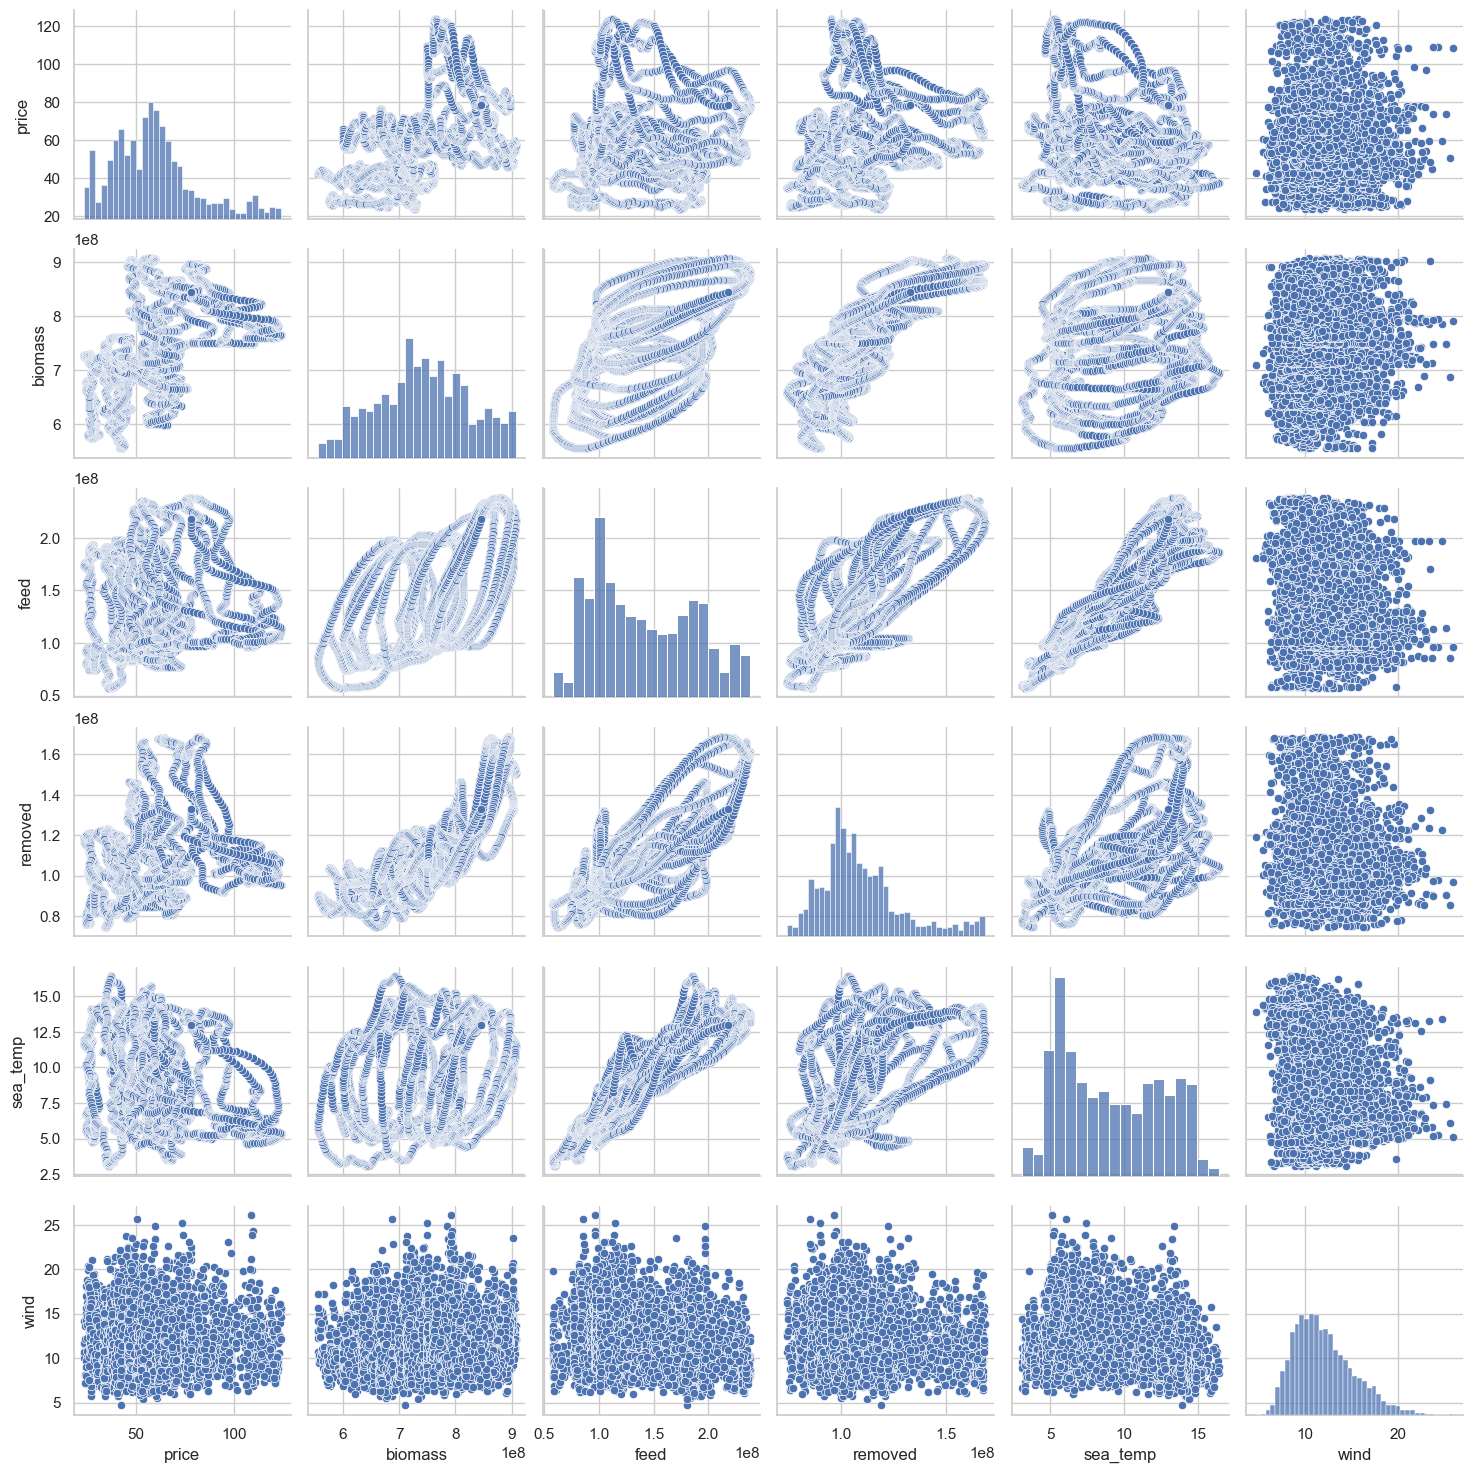

In [ ]:
# Make pariplot 
sns.pairplot(df_D)
plt.show()

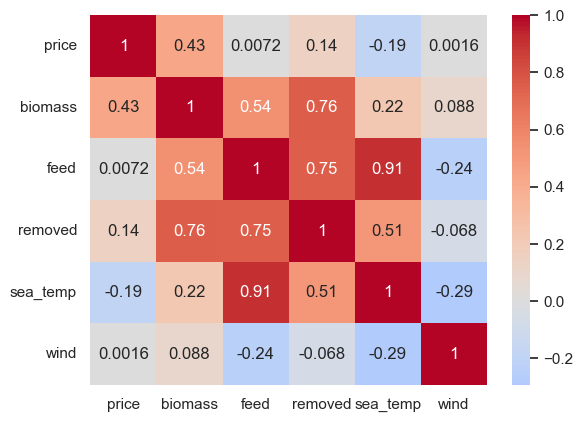

In [ ]:
df_numeric = df_D.select_dtypes(include=['float64', 'int64'])

#Pearson correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

Why do we observe these correlations?

### Make furhter analysis to train model

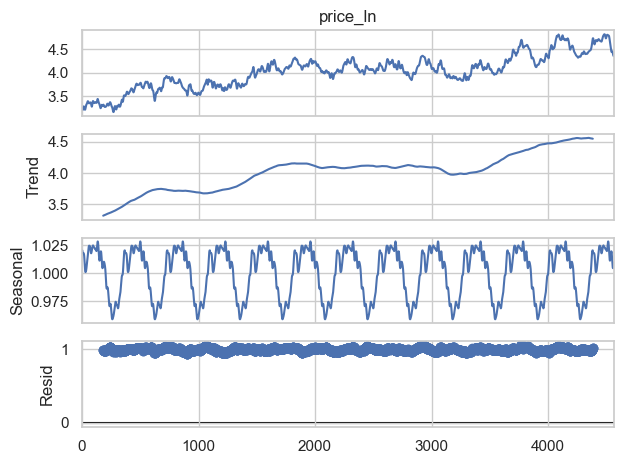

In [ ]:
decomposition = seasonal_decompose(df_D['price_ln'], model='multiplicative', period=365)

# Plot the decomposed components
decomposition.plot()
plt.show()

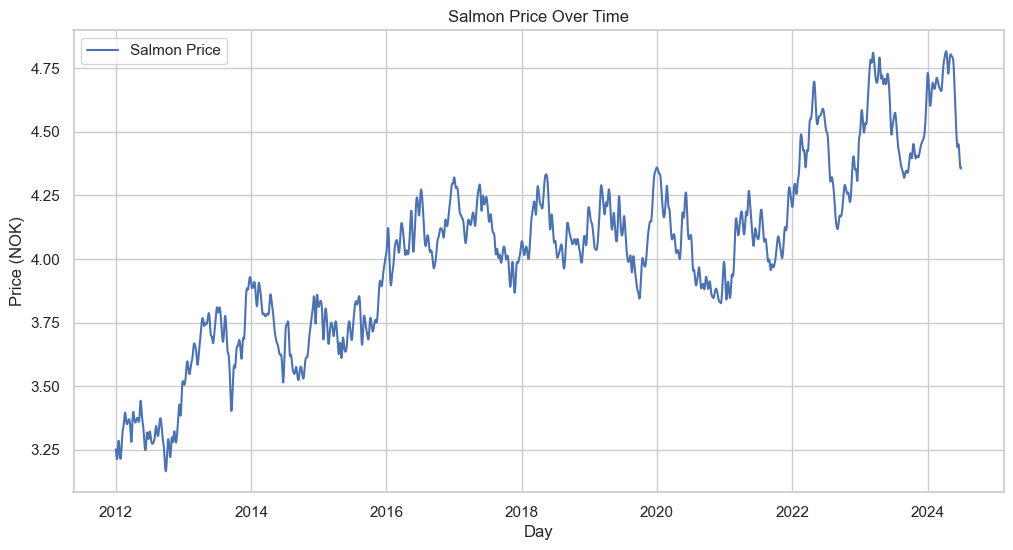

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df_D.index, df_D['price_ln'], label='Salmon Price')
plt.xlabel('Day')
plt.ylabel('Price (NOK)')
plt.title('Salmon Price Over Time')
plt.legend()
plt.show()

In [34]:
df_D = df_D.apply(pd.to_numeric, errors='coerce')
df_D_scaled = (df_D - df_D.min()) / (df_D.max() - df_D.min())
df_D_scaled['date'] = df_D.index
df_D_scaled.set_index('date', inplace=True)
df_D_scaled.index = pd.to_datetime(df_D.index)
df_D_scaled = df_D_scaled.last('8Y')

<bound method NDFrame.head of                price   biomass      feed   removed  sea_temp      wind  \
date                                                                     
2012-01-01  0.021314  0.356096  0.213710  0.096807  0.294285  0.566691   
2012-01-02  0.019569  0.355264  0.210509  0.090653  0.294285  0.464705   
2012-01-03  0.017638  0.354328  0.207202  0.084571  0.289735  0.538856   
2012-01-04  0.015687  0.353292  0.203798  0.078585  0.285612  0.618152   
2012-01-05  0.013915  0.352158  0.200312  0.072719  0.281859  0.419093   
...              ...       ...       ...       ...       ...       ...   
2024-06-27  0.543796  0.805026  0.828017  0.586036  0.728088  0.192031   
2024-06-28  0.542956  0.809728  0.842223  0.594922  0.732845  0.362472   
2024-06-29  0.543253  0.814516  0.856892  0.603950  0.737054  0.389893   
2024-06-30  0.544354  0.819391  0.872036  0.613122  0.740755  0.303031   
2024-07-01  0.545929  0.824356  0.887665  0.622439  0.743988  0.290352   

       

C:\Users\jespe\AppData\Local\Temp\ipykernel_39512\3220607916.py:7: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_D_scaled = df_D_scaled.last('8Y')
C:\Users\jespe\AppData\Local\Temp\ipykernel_39512\3220607916.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_D_scaled = df_D_scaled.last('8Y')


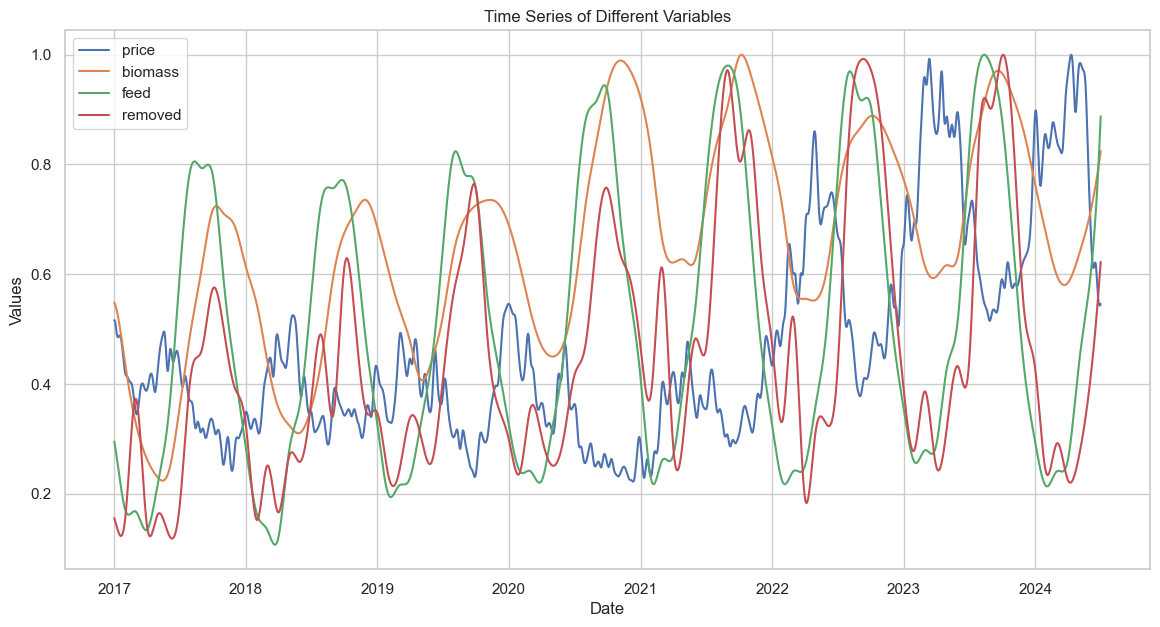

In [93]:
plt.figure(figsize=(14, 7))

# Loop through each column and plot on the same figure
for column in ['price', 'biomass', 'feed', 'removed']:
    plt.plot(df_D_scaled.index, df_D_scaled[column], label=column)

plt.title('Time Series of Different Variables')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [37]:
# Create a smaller dataset from 2019 and onwards
df_S = df_D[df_D.index >= '2019-01-01']
print(df_S)

                price       biomass          feed       removed   sea_temp  \
date                                                                         
2019-01-01  66.348603  7.964883e+08  1.164133e+08  1.071864e+08   6.648030   
2019-01-02  65.965256  7.956495e+08  1.155198e+08  1.070164e+08   6.624020   
2019-01-03  65.536552  7.948041e+08  1.146163e+08  1.068183e+08   6.610941   
2019-01-04  65.089082  7.939525e+08  1.137048e+08  1.065937e+08   6.605795   
2019-01-05  64.649439  7.930949e+08  1.127873e+08  1.063443e+08   6.605584   
...               ...           ...           ...           ...        ...   
2024-06-27  78.026901  8.384615e+08  2.070554e+08  1.296429e+08  12.778978   
2024-06-28  77.943025  8.401132e+08  2.096221e+08  1.304783e+08  12.842510   
2024-06-29  77.972624  8.417952e+08  2.122725e+08  1.313271e+08  12.898737   
2024-06-30  78.082637  8.435078e+08  2.150088e+08  1.321894e+08  12.948181   
2024-07-01  78.240000  8.452517e+08  2.178327e+08  1.330654e+08 

In [38]:
adf_result = adfuller(df_S['price_ln'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.0541810764531503
p-value: 0.26333299483471745


In [39]:
df_S['price_diff'] = df_S['price_ln'].diff().dropna()

# Check stationarity after differencing
adf_result_diff = adfuller(df_S['price_diff'].dropna())
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

ADF Statistic (Differenced): -6.87313087884454
p-value (Differenced): 1.4978706882964518e-09


C:\Users\jespe\AppData\Local\Temp\ipykernel_39512\3186104287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S['price_diff'] = df_S['price_ln'].diff().dropna()


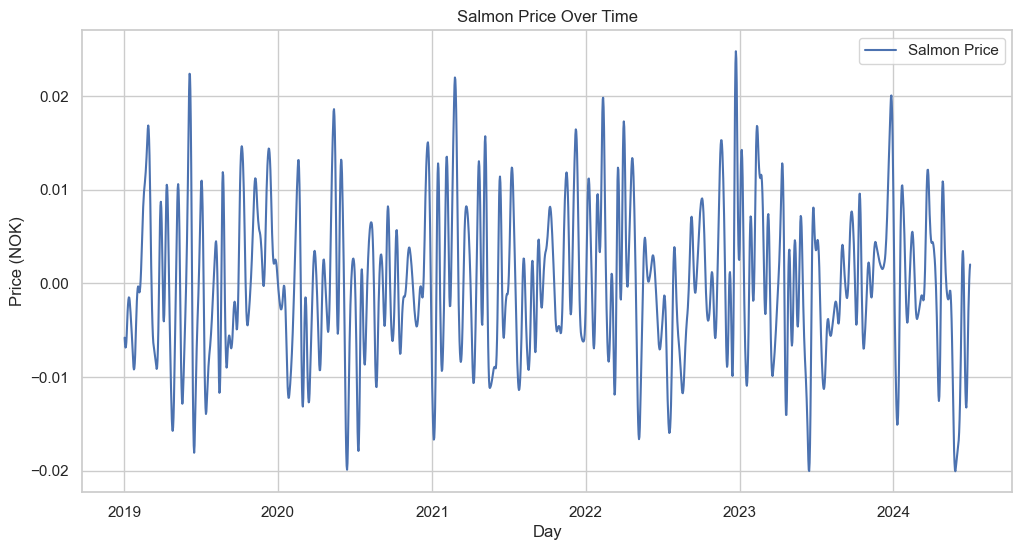

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df_S.index, df_S['price_diff'], label='Salmon Price')
plt.xlabel('Day')
plt.ylabel('Price (NOK)')
plt.title('Salmon Price Over Time')
plt.legend()
plt.show()

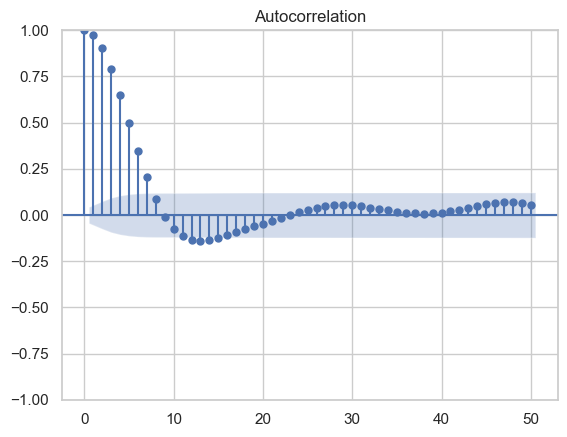

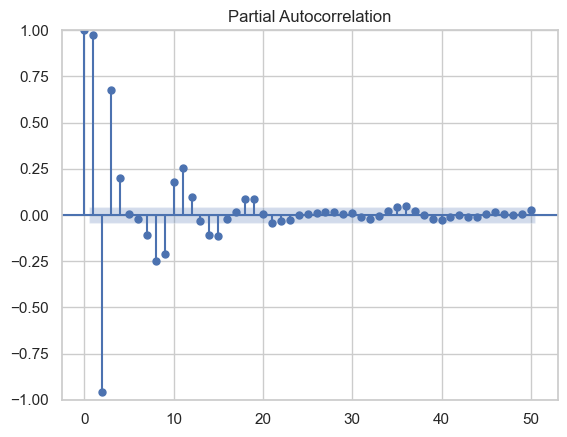

In [41]:
# Plot ACF and PACF for the differenced data

plot_acf(df_S['price_diff'].dropna(), lags=50)
plot_pacf(df_S['price_diff'].dropna(), lags=50)
plt.show()

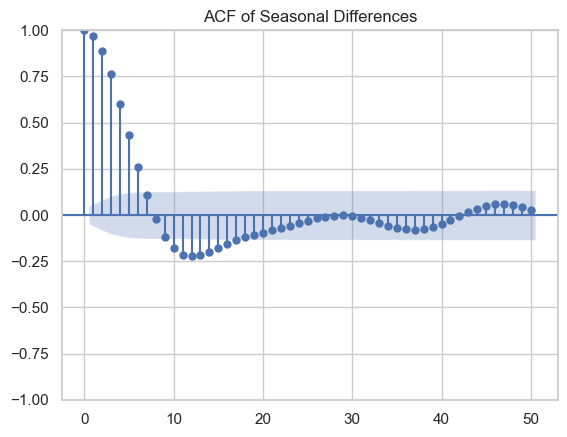

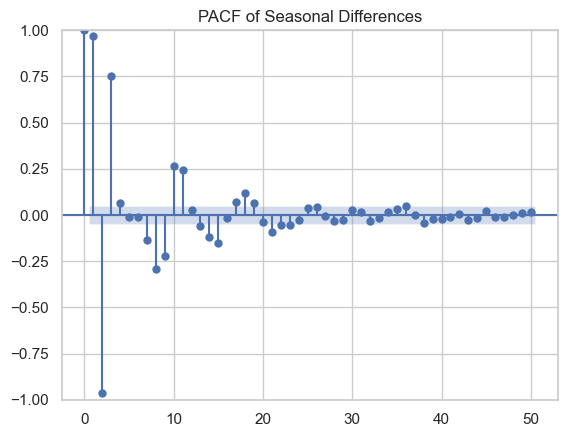

In [42]:
# Plot ACF and PACF for the seasonal part
seasonal_diffs = df_S['price_diff'].diff(365).dropna()
plot_acf(seasonal_diffs, lags=50)
plt.title('ACF of Seasonal Differences')
plt.show()

plot_pacf(seasonal_diffs, lags=50)
plt.title('PACF of Seasonal Differences')
plt.show()

It looks  like we are dealing with an ARIMA model with seasonality, indicated by the exponential decay of the ACF and PACF (the PACF plot is a little less clear). My initial guesses are ARIMA(3/4,1,0) as a baseline or ARIMA(1,1,1). However, the large correlations found far out into the PACF plot makes me wonder. Also it is indicated by the seasonal ACF and PACF that there is a yearly seasonal effect I beleieve we need maybe an SARIMAX(3,1,1)(3,1,0)[365]. I will use auto_arima to determine the model with the lowest AIC and BIC and then maybe compare agianst a model with a seasonal effect as well.

In [44]:
# Split the data into training and testing sets
train_data = df_S[df_S.index <= '2023-12-31']
test_data = df_S[df_S.index >= '2024-01-01']

In [46]:
print(train_data)

                 price       biomass          feed       removed  sea_temp  \
date                                                                         
2019-01-01   66.348603  7.964883e+08  1.164133e+08  1.071864e+08  6.648030   
2019-01-02   65.965256  7.956495e+08  1.155198e+08  1.070164e+08  6.624020   
2019-01-03   65.536552  7.948041e+08  1.146163e+08  1.068183e+08  6.610941   
2019-01-04   65.089082  7.939525e+08  1.137048e+08  1.065937e+08  6.605795   
2019-01-05   64.649439  7.930949e+08  1.127873e+08  1.063443e+08  6.605584   
...                ...           ...           ...           ...       ...   
2023-12-27  104.790290  8.296142e+08  1.139958e+08  1.167773e+08  6.150752   
2023-12-28  106.845433  8.284903e+08  1.133272e+08  1.164489e+08  6.075075   
2023-12-29  108.779661  8.273692e+08  1.126615e+08  1.160931e+08  5.995879   
2023-12-30  110.497289  8.262516e+08  1.119978e+08  1.157070e+08  5.915595   
2023-12-31  111.902630  8.251383e+08  1.113350e+08  1.152878e+08

In [76]:
y_train = train_data['price_ln']
X_train = train_data[['biomass', 'feed', 'sea_temp', 'wind']]

# Create model
model = SARIMAX(y_train, exog=X_train, order=(4, 1, 2))

# Fit the model
model_fit = model.fit(disp=False)

# Print the summary of the model
print(model_fit.summary())

# Now let's test the model on the test data
X_test = test_data[['biomass', 'feed', 'sea_temp', 'wind']]
y_test = test_data['price_ln']

# Make predictions
predictions_ln = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=X_test)

# Convert predictions back to original scale by applying the exponential function
predictions = np.exp(predictions_ln)

c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               price_ln   No. Observations:                 1826
Model:               SARIMAX(4, 1, 2)   Log Likelihood               11951.135
Date:                Sun, 01 Sep 2024   AIC                         -23880.270
Time:                        11:50:30   BIC                         -23819.667
Sample:                    01-01-2019   HQIC                        -23857.915
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
biomass    -2.008e-09   6.34e-10     -3.166      0.002   -3.25e-09   -7.65e-10
feed        2.301e-10   7.55e-10      0.305      0.761   -1.25e-09    1.71e-09
sea_temp      -0.0066      0.005     -1.397      0.1

c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


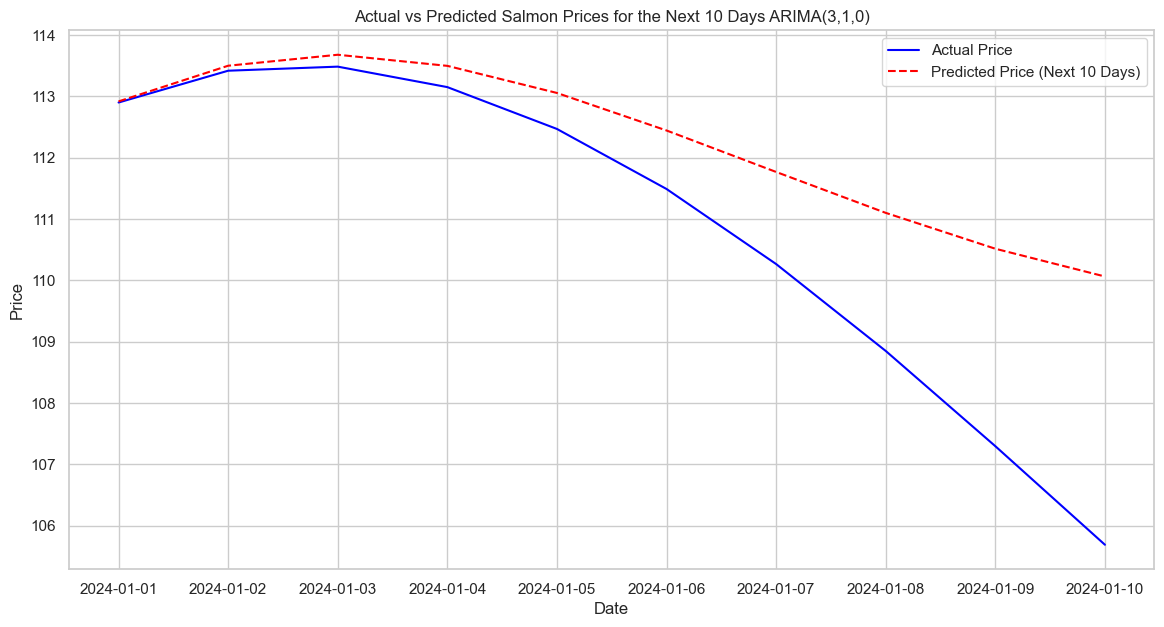

In [77]:
# Forecast the next 10 days
forecast = model_fit.get_forecast(steps=10, exog=X_test.iloc[:10])

# Extract the predicted mean prices
predicted_mean = np.exp(forecast.predicted_mean)

# Get the dates for the next 10 days
forecast_dates = test_data.index[:10]

# Plot the actual prices vs. the predicted prices for the next 10 days
plt.figure(figsize=(14, 7))

# Plot the actual values for the next 10 days
plt.plot(forecast_dates, test_data['price'].iloc[:10], label='Actual Price', color='blue')

# Plot the predicted values for the next 10 days
plt.plot(forecast_dates, predicted_mean, label='Predicted Price (Next 10 Days)', color='red', linestyle='--')
plt.title('Actual vs Predicted Salmon Prices for the Next 10 Days ARIMA(3,1,0)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [78]:
mse = mean_squared_error(test_data['price'].iloc[:10], predicted_mean)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate the R^2
r2 = r2_score(test_data['price'].iloc[:10], predicted_mean)
print(f'R-squared (R^2): {r2}')

Mean Squared Error (MSE): 3.8219256037918656
Root Mean Squared Error (RMSE): 1.9549745788096238
R-squared (R^2): 0.4509509436452531


In [ ]:
# Fit the auto_arima model without seasonal component
auto_model = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True 
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58156.335, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30339.362, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42955.279, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30332.848, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-53732.117, Time=2.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57805.135, Time=1.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-60932.048, Time=1.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52043.598, Time=3.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-60937.420, Time=4.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-57540.694, Time=3.87 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-58871.230, Time=2.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-55934.150, Time=5.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-60967.851, Time=2.93 sec
 ARIMA(2,1,3

The auto_arima chose ARIMA(4,1,4) using the AIC

In [ ]:
auto_model = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    information_criterion='AIC'                     
)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=-48605.301, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-25290.326, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-35716.481, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-25294.175, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=-44701.649, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=-48399.073, Time=1.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=-50818.567, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=-43518.748, Time=1.65 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : BIC=-50823.623, Time=2.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=-48070.992, Time=3.06 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : BIC=-49082.023, Time=4.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : BIC=-46722.033, Time=4.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : BIC=-50842.307, Time=1.91 sec
 ARIMA(2,1,3

The auto_arima agrees when using the BIC as criteria

After testing it was found that the model sugested by auto_arima is not good when tested with normal SARIMAX model, AIC blows up and it does not forecast well

### Do rolling window to evaluate the performance

In [100]:
def rolling_window_arimax(df, target_col, exog_cols, order, initial_train_end, forecast_horizon=10, log_trans=True):
    """
    Perform rolling window validation on a time series dataset using an ARIMAX model.

    Parameters:
    - df: pd.DataFrame, the dataset containing the time series data.
    - target_col: str, the name of the column to forecast.
    - exog_cols: list of str, the names of the exogenous variables columns.
    - order: tuple, the (p, d, q) order for the ARIMAX model.
    - initial_train_end: str, the end date of the initial training period (format 'YYYY-MM-DD').
    - forecast_horizon: int, the number of days to forecast in each rolling step (default is 10).

    Returns:
    - mean_mse: dict, mean MSE for each forecast horizon (1 to forecast_horizon days).
    - mean_rmse: dict, mean RMSE for each forecast horizon (1 to forecast_horizon days).
    - mean_r2: dict, mean R² for each forecast horizon (1 to forecast_horizon days).
    """

    # Initial setup
    initial_train_data = df[df.index <= initial_train_end]
    test_data = df[df.index > initial_train_end]

    # Create containers for the metrics
    mse_list = {i: [] for i in range(1, forecast_horizon + 1)}
    rmse_list = {i: [] for i in range(1, forecast_horizon + 1)}

    # Start the rolling window validation
    for start in range(len(test_data) - forecast_horizon + 1):
        # Expand the training data by one more day in each iteration
        train_data = pd.concat([initial_train_data, test_data.iloc[:start]])

        # Define the exogenous variables
        exog_train = train_data[exog_cols]
        exog_test = test_data[exog_cols].iloc[start:start + forecast_horizon]

        # Train the ARIMAX model
        model = ARIMA(train_data[target_col], order=order, exog=exog_train)
        model_fit = model.fit()

        # Forecast the next forecast_horizon days
        forecast = model_fit.forecast(steps=forecast_horizon, exog=exog_test)
        if log_trans==True:
            forecast = np.exp(forecast)
            actual_values = np.exp(test_data[target_col].iloc[start:start + forecast_horizon])
        else:
            actual_values = test_data[target_col].iloc[start:start + forecast_horizon]

        

        # Calculate and store the metrics for each day from 1 to forecast_horizon
        for i in range(1, forecast_horizon + 1):
            mse = mean_squared_error(actual_values[:i], forecast[:i])
            rmse = np.sqrt(mse)

            mse_list[i].append(mse)
            rmse_list[i].append(rmse)

    # Calculate the mean MSE, RMSE, and R² for each forecast horizon
    mean_mse = {i: np.mean(mse_list[i]) for i in range(1, forecast_horizon + 1)}
    mean_rmse = {i: np.mean(rmse_list[i]) for i in range(1, forecast_horizon + 1)}

    return mean_mse, mean_rmse

In [102]:
mean_mse, mean_rmse = rolling_window_arimax(
    df=df_S, 
    target_col='price_ln', 
    exog_cols=['biomass', 'feed', 'sea_temp', 'wind'], 
    order=(4, 1, 2), 
    initial_train_end='2022-12-31', 
    forecast_horizon=10
)

c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jespe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

In [ ]:
mean_mse_D, mean_rmse_D = rolling_window_arimax(
    df=df_D, 
    target_col='price_ln', 
    exog_cols=['biomass', 'feed', 'sea_temp', 'wind'], 
    order=(4, 1, 2), 
    initial_train_end='2022-12-31', 
    forecast_horizon=10
)

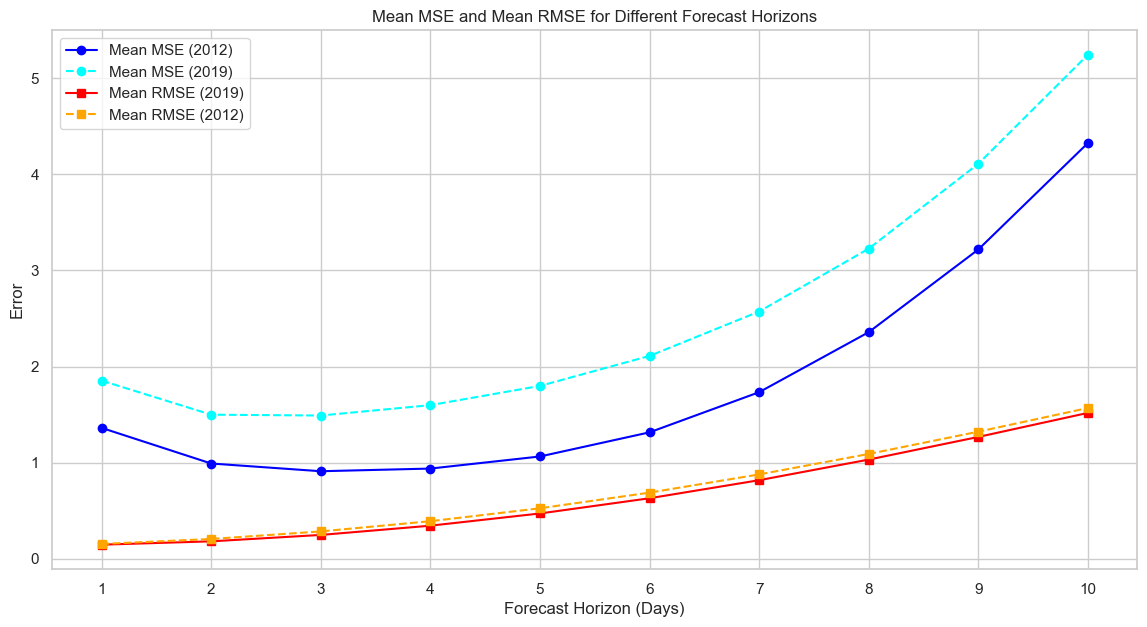

In [103]:
horizons = list(mean_mse.keys())
mse_values = list(mean_mse.values())
rmse_values = list(mean_rmse.values())
mse_values_D = list(mean_mse_D.values())
rmse_values_D = list(mean_rmse_D.values())

# Plotting the Mean MSE and Mean RMSE on the same plot
plt.figure(figsize=(14, 7))

# Plot Mean MSE
plt.plot(horizons, mse_values, marker='o', linestyle='-', color='blue', label='Mean MSE (2012)')
plt.plot(horizons, mse_values_D, marker='o', linestyle='--', color='cyan', label='Mean MSE (2019)')

# Plot Mean RMSE
plt.plot(horizons, rmse_values, marker='s', linestyle='-', color='red', label='Mean RMSE (2019)')
plt.plot(horizons, rmse_values_D, marker='s', linestyle='--', color='orange', label='Mean RMSE (2012)')

plt.title('Mean MSE and Mean RMSE for Different Forecast Horizons')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Error')
plt.xticks(horizons)
plt.legend()
plt.grid(True)
plt.show()